# 財報附註嚴重影響財務比率的判讀(1)：EPS與常續性EPS

每股盈餘是從事基本面投資最重要的財務指標

一間公司每年每股股票可以賺多少錢，也就代表投資人買一股該公司股票可以賺多少錢

能每年穩定獲利成長的公司，股價才會因為值得長期持有而穩定上漲

但是EPS每股盈餘卻有許多計算上的陷阱，存在於未經進一步處理過的財務報表上

這邊以宏達電為例，宏達電近年經營績效逐漸惡化，每股盈餘一直都是負值

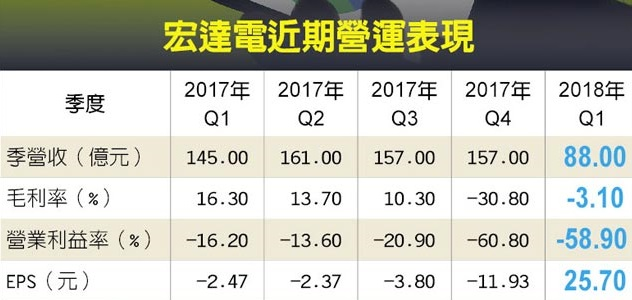

我們一樣執行"如何合併日股價與季財務簡表"這篇提到的python函式，查詢宏達電2017~2018的每季財務報表如下：

In [2]:
%load merge_finance_price.py

In [28]:
import pandas as pd
import tejapi  
tejapi.ApiConfig.api_key = "TEJAPIKEY"
table_kind = 'TWN'                          #資料國別名稱，輸入TRIAL則為試用資料庫
sampledates = ['2017-01-01','2018-12-31']   #要查詢的資料日期區間，必填
check_coid = ['2498']                       #要查詢的股票代碼 ，可以輸入空值[]，則自動查詢全部代碼   
account_kind = ['損益表','指標']             #要查詢的財務指標類型關鍵字，可輸入多個，會自動去除重覆 
#執行此function即可取得合併結果
mf = merge_finance_price_all()
data = mf.do_merge(table_kind,check_coid,sampledates,account_kind)


由於查詢的是季報表的資料，為了計算移動四季，也就是財報揭露時間點往回推一整年的每股盈餘

要進行移動窗口的加總的動作，寫入到新的欄位'每股盈餘(移動四季)'

In [29]:
eps = data['每股盈餘'].unique().tolist()
eps

[-2.47, -2.37, -3.8, -11.93, 25.7, -2.53, -3.18]

In [30]:
moving_eps = [ eps[i]+eps[i-1]+eps[i-2]+eps[i-3]   for i in range(3,len(eps))]
for i in range(0,len(eps)-3):
    data.loc[data['每股盈餘']==eps[i+3],'每股盈餘(移動四季)'] = moving_eps[i]   

In [31]:
eps = data['每股盈餘(移動四季)'].unique().tolist()
eps

[nan, -20.57, 7.599999999999999, 7.439999999999999, 8.059999999999999]

查詢完成後，將股價、每股盈餘畫出線圖，就發現了奇妙的情形：

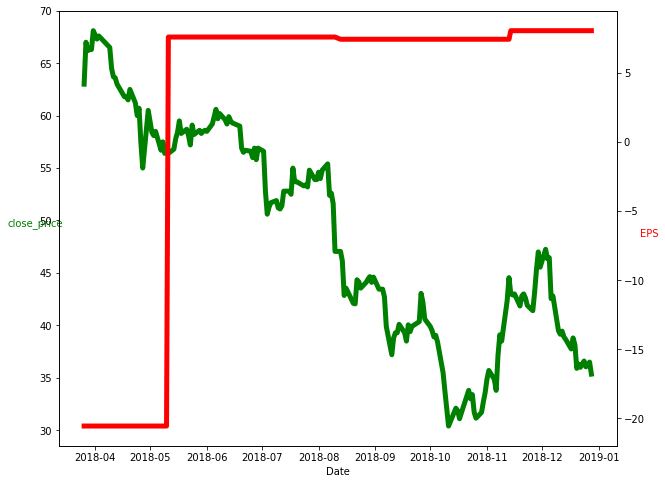

In [32]:
import matplotlib.pyplot as plt
data = data[data['每股盈餘(移動四季)'].isnull()==False]
xy = data.reindex(columns=['mdate','close_d','每股盈餘(移動四季)']).values

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
xy = xy[xy[:,0].argsort()]
ax1.plot(xy[:, 0], xy[:, 1], linewidth=5,color='green')
ax2.plot(xy[:, 0], xy[:, 2], linewidth=5,color='red' )
ax1.set_xlabel('Date')
yx1 = ax1.set_ylabel('close_price', color='green')
yx1.set_rotation(0)
yx2 = ax2.set_ylabel('EPS', color='red')
yx2.set_rotation(0)
plt.show()  

從上面這張圖可以看到，紅色線代表移動四季(該時間點過去四個季的加總)每股盈餘

到2018年年初一直為負的每股盈餘，而且是-20以上

2018年第一季財報在五月發布後，每股盈餘竟然突然變成正的

而且還是非常高的每股盈餘8元的離譜數字

跟上面新聞圖片提到的一樣，但是股價(綠色線)卻沒有因此回彈，反而一路下滑

這是因為宏達電的每股盈餘在2018年Q1爆增，靠的是宏達電出售製作pixel手機的部門給google

實現了巨額營業外收入，紀錄在宏達電損益表的"其他利益"這項如下：
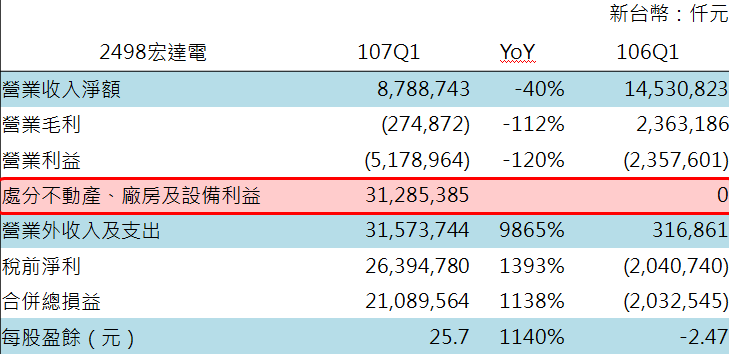

把部門賣掉並不是HTC的核心業務，也不見得會改善公司的未來營運

因此雖然每股盈餘突然提高到過去幾年從未有的水準

HTC的股價也是欲振乏力，持續向下；

但如果我們看的不是損益表上揭露的每股盈餘

而是TEJ調整過，只計算公司本業持續性收支的「常續性EPS」，繪製出來的圖就不太一樣了

而且常續性EPS在計算時，TEJ已經自動計算轉換為移動四季，可以不用另外處理，就可以使用：

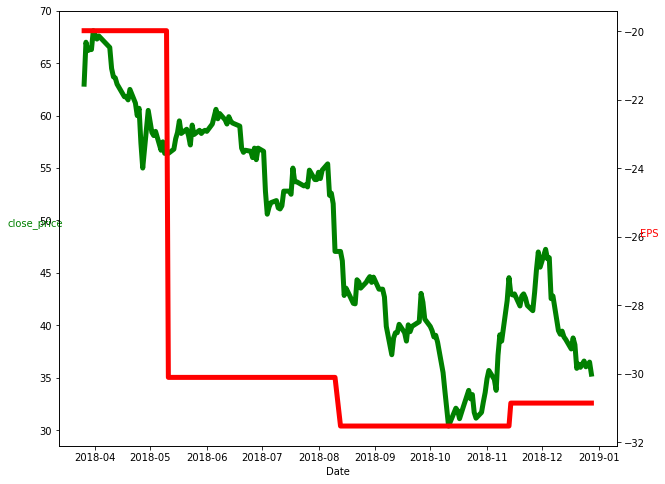

In [33]:
import matplotlib.pyplot as plt

xy = data[(data['mdate']>'2017-11-01')].reindex(columns=['mdate','close_d','常續性EPS']).values

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
xy = xy[xy[:,0].argsort()]
ax1.plot(xy[:, 0], xy[:, 1], linewidth=5,color='green')
ax2.plot(xy[:, 0], xy[:, 2], linewidth=5,color='red' )
ax1.set_xlabel('Date')
yx1 = ax1.set_ylabel('close_price', color='green')
yx1.set_rotation(0)
yx2 = ax2.set_ylabel('EPS', color='red')
yx2.set_rotation(0)
plt.show()  

從上圖可以看到，從2017年起，宏達電的常續性EPS確實與股價走勢一致、持續下跌

在進行基本面投資時，務必要以該公司本業核心、持續性獲利能力來考量其獲利能力

而非曇花一現的短期獲利結果，導致誤判